# COGS 108 - Final Project: Vehicle Stops in San Diego

### Group Members: 
- Louise Xu (A12650425)
- David Tay (A10914210)
- Jeffrey Lu (A12177953)

### Goal of Project:
- To determine whether there is a correlation between the frequency of vehicle stops in San Diego and the time and locations at which they take place
- To examine possible reasons for the correlations, if any exist 

### Research Question
- Are there more vehicle stops at certain times and places than others? Does the frequency of vehicle stops vary significantly between different seasons?

### Hypothesis
- There will most likely be more traffic violations during periods of time with high traffic density (e.g. rush hour), during weekdays (when there are more people on the road who are driving to work), and during holiday seasons (since there would be more tourists and people visting family). On a broader scale, given that the population of San Diego is increasing, it reasonable to say that the number of traffic violations is also increasing at a similar rate. 
- We can also guess that the number of vehicle stops in more populated areas is greater than those in less populated areas.

In [1]:
# Import packages
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
from scipy.stats import ttest_ind

## Part 1: Load and Clean Data

In [2]:
# Import each vehicle stops data file into its own DataFrame
vs_14 = pd.read_csv('vehicle_stops_2014_datasd.csv')
vs_15 = pd.read_csv('vehicle_stops_2015_datasd.csv')
vs_16 = pd.read_csv('vehicle_stops_2016_datasd.csv')
vs_17 = pd.read_csv('vehicle_stops_2017_datasd.csv')

# Join the data for each year together into one DataFrame
# Note: The file for vs_17 contained two more columns (both of them empty and unnamed) than the datasets for the other years 
# These two columns were deleted on Microsoft Excel in order to successfully merge the four datasets together
vs_all = pd.concat([vs_14, vs_15, vs_16, vs_17], ignore_index=True)

#Import police regions into a DataFrame
sd_neigh = pd.read_csv('pd_beat_neighborhoods_datasd.csv')

In [3]:
# Let's check to see how many observations are in each dataset
# Note: vs_17 is year to date data from 2017, so there is data up to May of 2017 (the period in which this analysis is conducted)
print(vs_14.shape)
print(vs_15.shape)
print(vs_16.shape)
print(vs_17.shape)

(144164, 15)
(115422, 15)
(103051, 15)
(28362, 15)


We can see here that the number of vehicle stops is actually *decreasing* each year between 2014 and 2016. Also, while we can not take the 2017 data into direct consideration because we only have data up to March, we can predict the total number of vehicle stops at the end of this year based on our current data (28362 stops) divided by the three months that have already passed and then multiplied by the twelve months of the year, which results in (28362)(12)/3 = 113448 stops. While this number is larger than the number of stops in 2016, it is still smaller than the number of stops in 2014 and 2015, which follows the trend of decreasing vehicle stops in San Diego.

In [4]:
# Let's start cleaning up the data

# We won't be using these columns
vs_all.drop(['arrested', 'searched', 'obtained_consent', 'contraband_found', 'property_seized', 'stop_time', 'stop_date', 'stop_id'], axis=1, inplace=True, errors='ignore')

# Get rid of rows with invalid data
vs_all.dropna(inplace=True)
vs_all = vs_all.loc[(vs_all['service_area'] != 'Unknown')]
# 630, 130 service areas don't exist, 840 is rolando park but it doesn't show up in Zillow
vs_all = vs_all.loc[(vs_all['service_area'] != '630') & (vs_all['service_area'] != '130') & (vs_all['service_area'] != '840')]


# Only keep data of stops involving San Diego residents
# vs_all = vs_all.loc[(vs_all['sd_resident'] == 'Y')]

# Cleaning the ages of the subjects, these characters occur in the dataset and we don't want these
try:
    vs_all = vs_all.loc[~(vs_all['subject_age'].str.contains("_|N|`|Q|F|Y|H", case=False))]
    vs_all[['subject_age']] = vs_all[['subject_age']].apply(pd.to_numeric)
except:
    pass

# Some stops have an X as the gender
vs_all = vs_all.loc[(vs_all['subject_sex'].str.contains("M|F", case=False))]

# Use Safe Harbor practices on the subject_ages
vs_all = vs_all.loc[(vs_all['subject_age'] <= 90) & (vs_all['subject_age'] >= 16)]

# Format all dates in datetime format
vs_all['timestamp'] = pd.to_datetime(vs_all.timestamp)

# Find the day of the week each stop took place
vs_all['weekday'] = vs_all['timestamp'].dt.dayofweek

# Find the month each stop took place
vs_all['month'] = vs_all['timestamp'].dt.month

# Clean Stop Causes
vs_all = vs_all.loc[~(vs_all['stop_cause'].str.contains("NOT|none|Other|no cause", case=False))]
vs_all['stop_cause'].replace('&Moving Violation', 'Moving Violation', inplace=True)
vs_all['stop_cause'].replace(['UNI, &County, H&&S Code', 'MUNI, County, H&S Code'] , 'Muni, County, H&S Code', inplace=True)
vs_all['stop_cause'].replace('&Radio Call/Citizen Contact'  , 'Radio Call/Citizen Contact', inplace=True)
vs_all['stop_cause'].replace('&Equipment Violation'  , 'Equipment Violation', inplace=True)
vs_all['stop_cause'].replace('Suspect Info'  , 'Suspect Info (I.S., Bulletin, Log)', inplace=True)
vs_all['stop_cause'].replace('Personal Observ/Knowledge'  , 'Personal Knowledge/Informant', inplace=True)

#630, 130 service araes don't exist

# Look at shape of data so far
vs_all

,stop_cause,service_area,subject_race,subject_sex,subject_age,timestamp,sd_resident,weekday,month
0,Moving Violation,110,W,M,24.0,2014-01-01 01:25:00,Y,2,1
1,Moving Violation,320,W,M,42.0,2014-01-01 05:47:00,Y,2,1
2,Moving Violation,320,L,M,29.0,2014-01-01 07:46:00,Y,2,1
3,Moving Violation,610,W,M,23.0,2014-01-01 08:10:00,Y,2,1
4,Equipment Violation,930,H,M,35.0,2014-01-01 08:35:00,N,2,1
5,Equipment Violation,820,H,M,30.0,2014-01-01 08:39:00,Y,2,1
6,Moving Violation,710,H,F,19.0,2014-01-01 09:13:00,N,2,1
7,Moving Violation,120,W,M,32.0,2014-01-01 09:50:00,Y,2,1
8,Moving Violation,120,W,M,36.0,2014-01-01 10:00:00,Y,2,1
9,Moving Violation,120,H,M,27.0,2014-01-01 10:40:00,Y,2,1


In [5]:
# Make additional datasets

# Create separate cleaned datasets for each year individually
vs_14 = vs_all[(vs_all['timestamp'].dt.year == 2014)]
vs_15 = vs_all[(vs_all['timestamp'].dt.year == 2015)]
vs_16 = vs_all[(vs_all['timestamp'].dt.year == 2016)]
vs_17 = vs_all[(vs_all['timestamp'].dt.year == 2017)]

# Create second cummulative dataset without data from 2017, since it is incomplete and will skew categorical distributions
vs_complete = vs_all[(vs_all['timestamp'].dt.year != 2017)]

## Part 2: Exploratory Data Vizualization

This will be divided into two parts:
- histogram of region (categorically: by police beats)
- histogram of time (categorically: by time of day, by day of the week, by month; temporally: by day, by month, by year)

And then additional histograms for fun:
- histogram of race
- histogram of gender
- histogram of age
- histogram of type of vehicle violation

Possibly plot a scatter matrix too

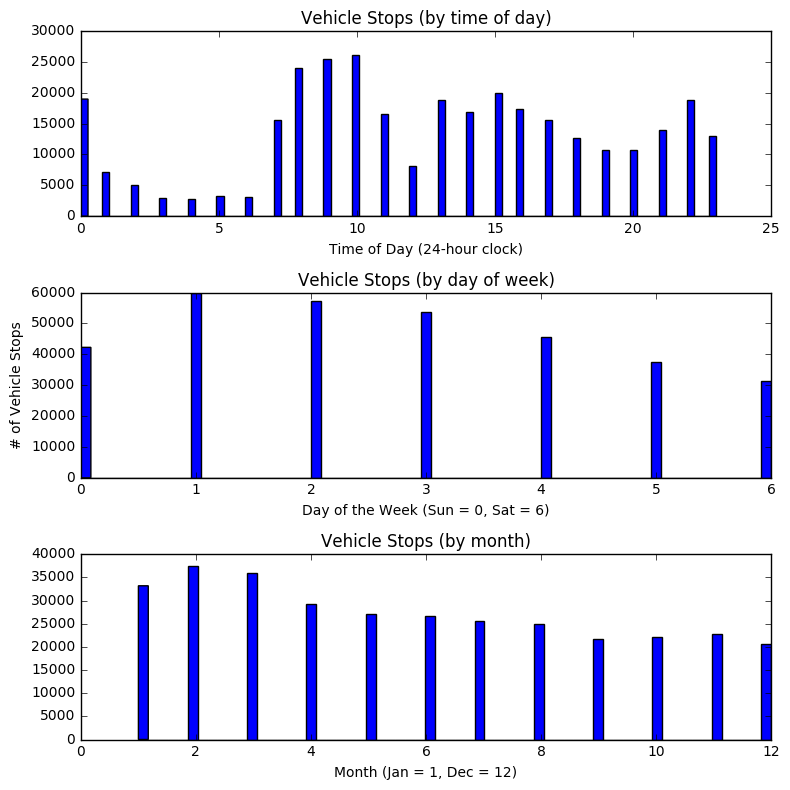

In [6]:
# Histograms of Vehicle Stops in terms of categorical time (on vs_all)

fig2 = plt.figure(figsize=(8, 8), dpi=100)

plt.subplot(311)
plt.xlabel('Time of Day (24-hour clock)')
plt.title("Vehicle Stops (by time of day)")
plt.hist(vs_all['timestamp'].dt.hour, bins='auto')

plt.subplot(312)
plt.xlabel('Day of the Week (Sun = 0, Sat = 6)')
plt.ylabel('# of Vehicle Stops')
plt.title("Vehicle Stops (by day of week)")
plt.hist(vs_all['weekday'], bins='auto')

plt.subplot(313)
plt.xlabel('Month (Jan = 1, Dec = 12)')
plt.title("Vehicle Stops (by month)")
plt.hist(vs_all['month'], bins='auto')

plt.tight_layout()
plt.show()

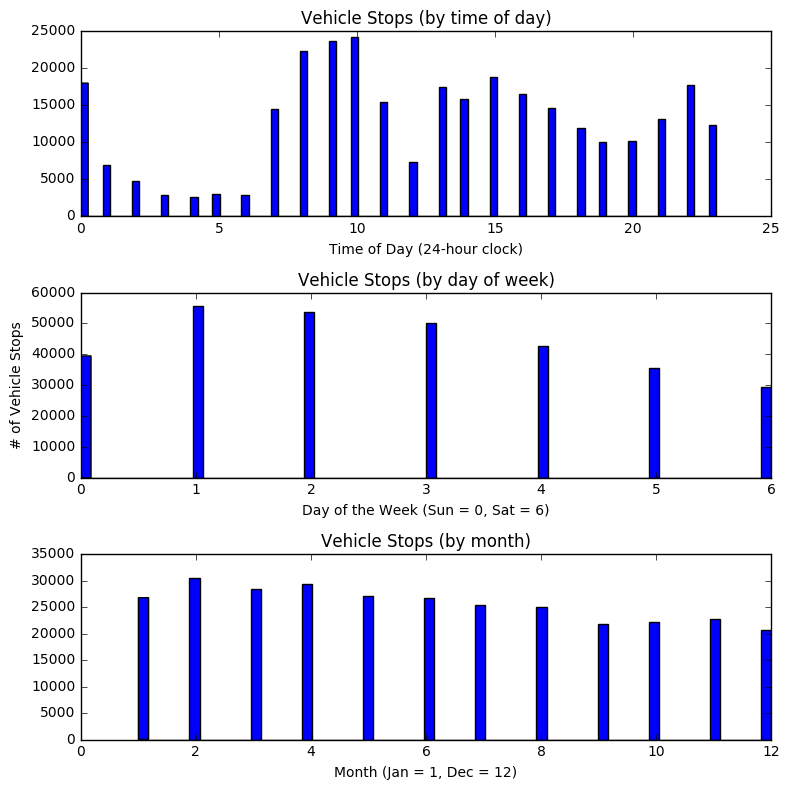

In [7]:
# Histograms of Vehicle Stops in terms of categorical time (on vs_complete)

fig2 = plt.figure(figsize=(8, 8), dpi=100)

plt.subplot(311)
plt.xlabel('Time of Day (24-hour clock)')
plt.title("Vehicle Stops (by time of day)")
plt.hist(vs_complete['timestamp'].dt.hour, bins='auto')

plt.subplot(312)
plt.xlabel('Day of the Week (Sun = 0, Sat = 6)')
plt.ylabel('# of Vehicle Stops')
plt.title("Vehicle Stops (by day of week)")
plt.hist(vs_complete['weekday'], bins='auto')

plt.subplot(313)
plt.xlabel('Month (Jan = 1, Dec = 12)')
plt.title("Vehicle Stops (by month)")
plt.hist(vs_complete['month'], bins='auto')

plt.tight_layout()
plt.show()

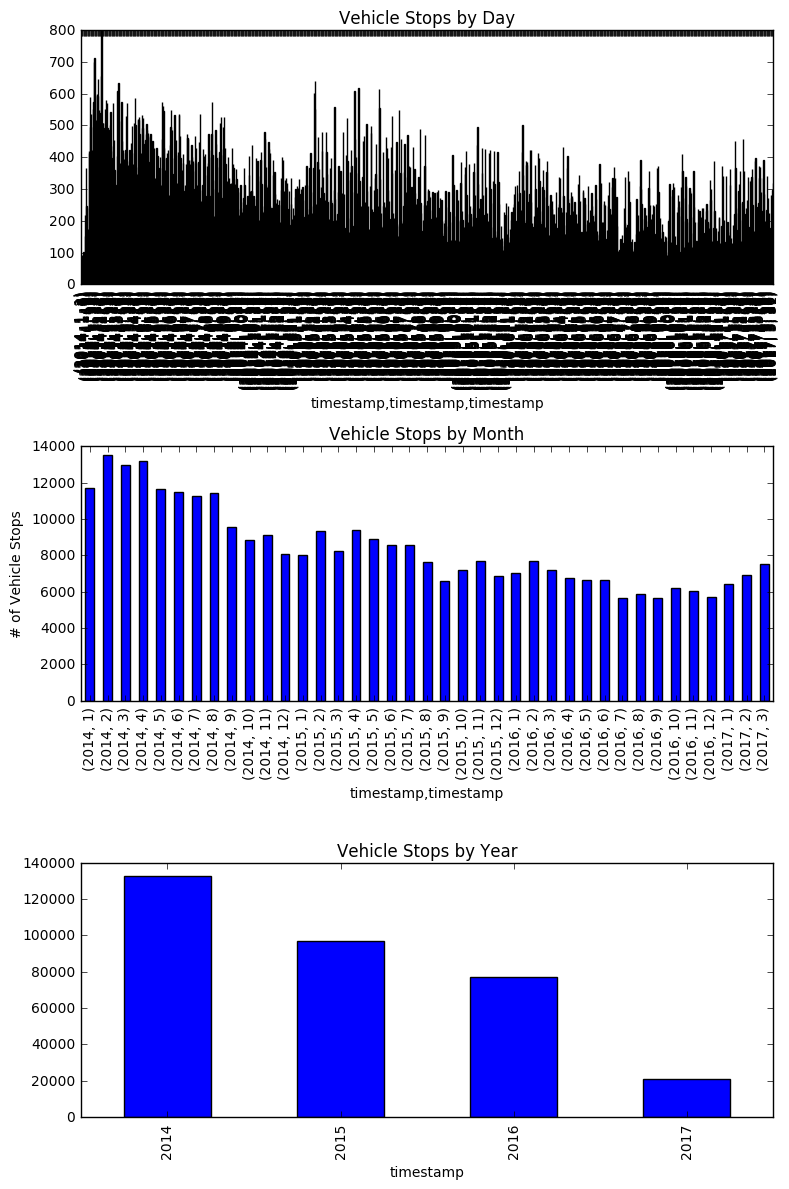

In [8]:
# Histograms of Vehicle Stops in terms of temporal time
# The three plots are essentially the same, they just have different bin sizes to give us different scales of time

year = vs_all["timestamp"].dt.year
month = vs_all["timestamp"].dt.month
day = vs_all["timestamp"].dt.day


fig2 = plt.figure(figsize=(8, 12), dpi=100)

plt.subplot(311)
plt.xlabel('Date (Year, Month, Day)')
plt.title("Vehicle Stops by Day")
vs_all["timestamp"].groupby([year, month, day]).count().plot(kind="bar")

plt.subplot(312)
plt.xlabel('Month (Year, Month)')
plt.ylabel('# of Vehicle Stops')
plt.title("Vehicle Stops by Month")
vs_all["timestamp"].groupby([year, month]).count().plot(kind="bar")

plt.subplot(313)
plt.xlabel('Year')
plt.title("Vehicle Stops by Year")
vs_all["timestamp"].groupby([year]).count().plot(kind="bar")

plt.tight_layout()
plt.show()

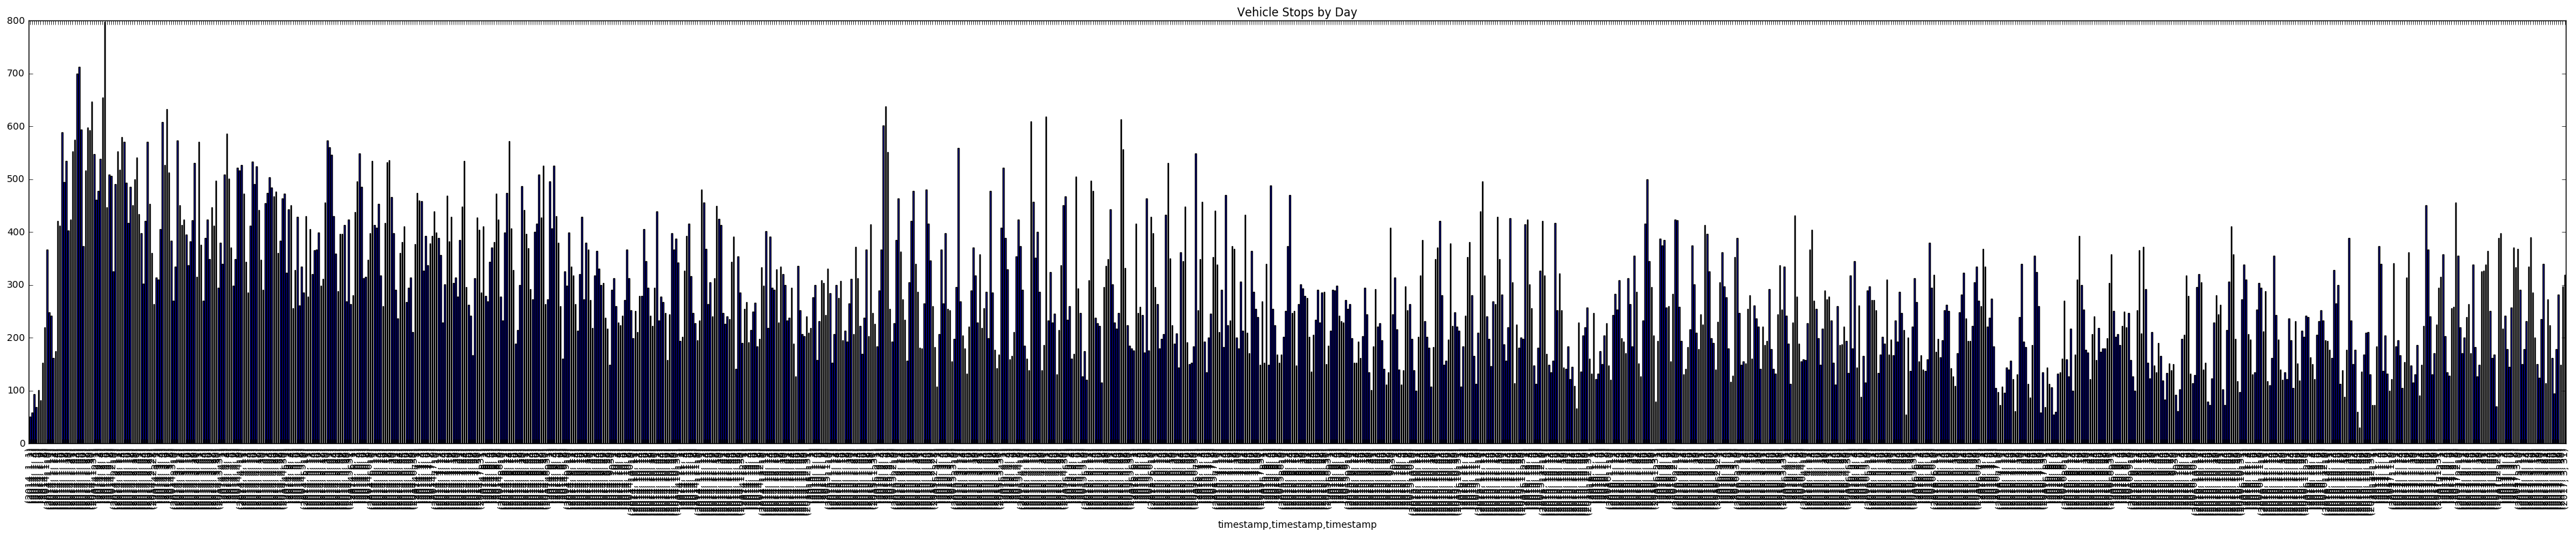

In [9]:
fig2 = plt.figure(figsize=(48, 8), dpi=100)

plt.subplot(111)
plt.xlabel('Date (Year, Month, Day)')
plt.title("Vehicle Stops by Day")
vs_all["timestamp"].groupby([year, month, day]).count().plot(kind="bar")

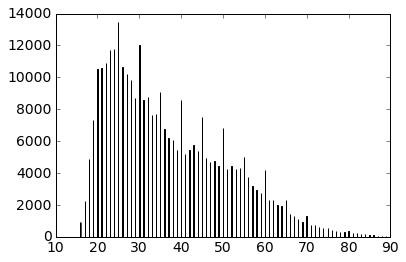

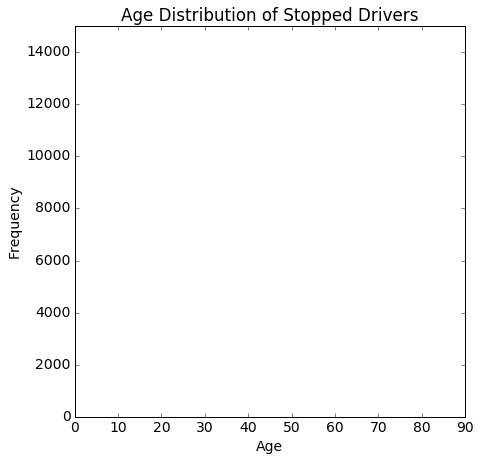

In [10]:
#Histograms of age from 2014 to 2017
age = plt.hist(vs_all['subject_age'], bins = 1000)
figure1 = plt.figure(figsize=(7,7))
plt.rcParams.update({'font.size': 14})
plt.axis([0, 90, 0, 15000])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution of Stopped Drivers')

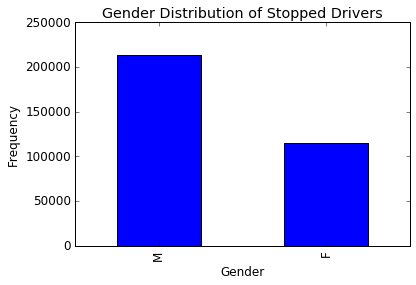

In [11]:
#Histograms of gender from 2014 to 2017
gender = vs_all['subject_sex'].value_counts()
plt.rcParams.update({'font.size': 12})
gender.plot('bar')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.title('Gender Distribution of Stopped Drivers')

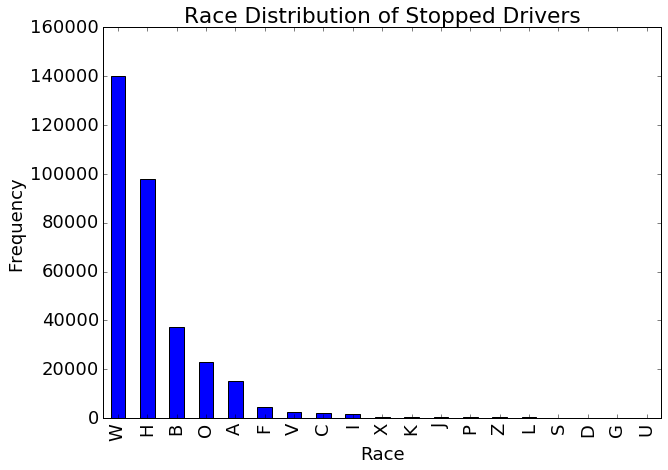

In [12]:
#Histograms of race from 2014 to 2017
race = vs_all['subject_race'].value_counts()
figure = plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 18})
race.plot('bar')
plt.xlabel('Race')
plt.ylabel('Frequency')
plt.title('Race Distribution of Stopped Drivers')

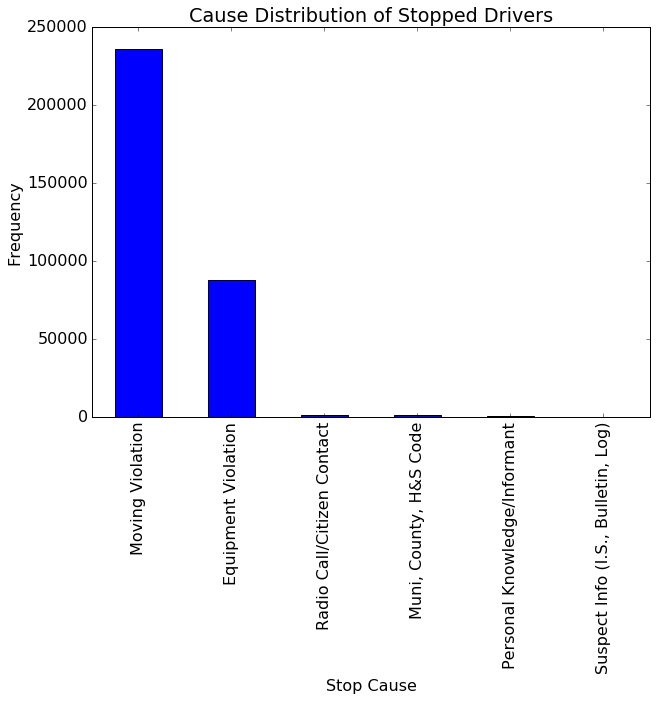

In [13]:
#Histograms of stop causes from 2014 to 2017
cause = vs_all['stop_cause'].value_counts()
figure2 = plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 16})
cause.plot('bar')
plt.xlabel('Stop Cause')
plt.ylabel('Frequency')
plt.title('Cause Distribution of Stopped Drivers')

## Part 3: Exploring The Data

Check the:
- range of ages
- range of violations in different regions
- range of violations at different times (time of day, day of week, month)
- regions with the most/least vehicle violations
- times with the most/least vehicle violations

In [14]:
age_range = vs_all['subject_age'].max() - vs_all['subject_age'].min()
print("The range of ages in our dataset is:\t", age_range)
print("The highest age in our dataset is:\t\t", vs_all['subject_age'].max())
print("The lowest age in our dataset is:\t\t", vs_all['subject_age'].min(), '\n')

range_regions = vs_complete['service_area'].value_counts()
print('Range of Regions:\n', range_regions, '\n', sep='')

range_time_of_day  = vs_complete['timestamp'].dt.hour.value_counts()
print('Range of Time of Day:\n', range_time_of_day, '\n', sep='')

range_day_of_week = vs_complete['weekday'].value_counts()
print('Range of Day of Week:\n', range_day_of_week, '\n', sep='')

range_month = vs_complete['month'].value_counts()
print('Range of Month:\n', range_month, '\n', sep='')

range_stop_causes = vs_complete['stop_cause'].value_counts()
print('Range of Stop Causes:\n', range_stop_causes, '\n', sep='')

The range of ages in our dataset is:	 74.0
The highest age in our dataset is:		 90.0
The lowest age in our dataset is:		 16.0 

Range of Regions:
120    26734
310    25748
520    24542
240    22574
110    19980
930    18688
620    18250
710    17940
230    17409
610    16017
720    15317
320    13541
510    12468
430    12018
810    11588
830    11529
440    11239
820    10663
530      530
Name: service_area, dtype: int64

Range of Time of Day:
10    24249
9     23691
8     22327
15    18784
0     17960
22    17670
13    17453
16    16428
14    15763
11    15401
17    14645
7     14497
21    13161
23    12332
18    11868
20    10097
19    10049
12     7338
1      6872
2      4787
5      3045
6      2882
3      2830
4      2646
Name: timestamp, dtype: int64

Range of Day of Week:
1    55753
2    53658
3    50079
4    42699
0    39486
5    35632
6    29468
Name: weekday, dtype: int64

Range of Month:
2     30512
4     29309
3     28355
5     27159
1     26795
6     26732
7     25492
8   

##### Install these packages before running:
- pip install pyshp
- pip install bokeh


In [15]:
# Sort police beats into service areas.
police_beats = pd.read_csv('pd_beat_neighborhoods_datasd.csv')
# Remove 'Oak Park' because data for 450 service area doesn't exist
police_beats = police_beats.loc[(police_beats['Neighborhood'] != 'Oak Park')]
police_beats['Beat'] = police_beats['Beat'].astype(str)
beats_from_data = police_beats['Neighborhood'].tolist()

# working with shapefiles
# neighborhood shapefile data from Zillow:
# https://www.zillow.com/howto/api/neighborhood-boundaries.htm
#
# shapefile package: pyshp
# https://pypi.python.org/pypi/pyshp

import shapefile

# read the in the shapefile and list the methods associated with the object
sf = shapefile.Reader("ZillowNeighborhoods-CA.shp")

# read in the dbf (metadata) file and list all the methods associated with it
sfdbf = shapefile.Reader("ZillowNeighborhoods-CA.dbf")

# find indices of all San Diego neighborhoods
metadata = sfdbf.shapeRecords()

sd_index = []
beats_from_zillow = []
final_beats_zillow = []

for i in range(len(metadata)):
    if metadata[i].record[1] == 'San Diego':
        beats_from_zillow.append(metadata[i].record[3])
        if metadata[i].record[3] in beats_from_data:
            final_beats_zillow.append(metadata[i].record[3])

# need to keep track of name in data to properly create service areas
final_beats_data = final_beats_zillow.copy()

for data in (set(beats_from_data) - set(beats_from_zillow)):
    for zillow in (set(beats_from_zillow) - set(beats_from_data)):
        # Some beats have similar starting substrings but the ending substring is different
        if data[0:4] == zillow[0:4] and data[-3:] == zillow[-3:]:
            final_beats_zillow.append(zillow)
            final_beats_data.append(data)

# Manual addition, can't find a good way to programmically add these
final_beats_zillow.append('Cortez Hill')
final_beats_zillow.append('Gaslamp Quarter')
final_beats_zillow.append('Jomacha-Lomita')
final_beats_zillow.append('Rancho Encantado')
#  'Broadway Heights', "O'Farrell", 'Petco Park', 'Qualcomm', and 'Rolando Park' are not in zillow

# Add in names that correspond to the data
final_beats_data.append('Cortez')
final_beats_data.append('Gaslamp')
final_beats_data.append('Jamacha/Lomita')
final_beats_data.append('Rancho Encantada')

# print (sorted(set(beats_from_data) - set(final_beats_data)))
    
# Need indices in order they were added to final beats to line up correctly
for beat in final_beats_zillow:
    for i in range(len(metadata)):
        if metadata[i].record[1] == 'San Diego' and metadata[i].record[3] == beat:
            sd_index.append(i)
            continue

# print("sd_index:",len(set(sd_index)))
# print('beat names:',len(beats_from_zillow))
# print('final beats:',len(final_beats_zillow))
# print('final beats:',len(final_beats_data))

# Get shapes of each beat
shapes = sf.shapes()
sd_shapes = []
for i in range(len(sd_index)):
    sd_shapes.append(shapes[sd_index[i]].points)

beats = []
beats_lons = []
beats_lats = []
for i in range(len(sd_shapes)):
    beats.append(sd_shapes[i])
    beats_lons.append([xy[0] for xy in beats[i]])
    beats_lats.append([xy[1] for xy in beats[i]])
    
# Group beats, indices by service area
service_areas = vs_complete['service_area'].value_counts().index.tolist()
beats_by_service_area = {}
index_by_service_area = {}
# Service area 450 doesn't exist
for area in sorted(service_areas):
    temp = police_beats.loc[(police_beats['Beat'].str[0:2] == area[0:2])]
    beats_by_service_area[area] = temp['Neighborhood'].tolist()
    indices = []
    for beat in temp['Neighborhood'].tolist():
        if beat in final_beats_data:
            indices.append(final_beats_data.index(beat))
    index_by_service_area[area] = indices.copy()
    
beats_in_dict = []
for x in beats_by_service_area.values():
    for b in x:
        beats_in_dict.append(b)

# array of service area numbers corresponding to index number
which_service_area_is_each_beat = [''] * len(final_beats_zillow)
for key in index_by_service_area:
    for index in index_by_service_area[key]:
        which_service_area_is_each_beat[index] = key

# Now to separate traffic stops by year and time of day
range_regions_all = vs_complete['service_area'].value_counts()
list_regions = range_regions_all.index.tolist() # Can't use a key to dereference range_regions_all 

# Get traffic stop counts for each service area
ts_per_sa = []
for area in which_service_area_is_each_beat:
    ts_per_sa.append(range_regions_all[list_regions.index(area)])

In [16]:
import bokeh
from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper
from bokeh.models.widgets import Slider, Select
from bokeh.palettes import YlOrRd9 as palette
from bokeh.plotting import figure, Figure, output_file, show
from bokeh.layouts import layout, widgetbox, column
from ipywidgets import interact
import numpy as np

# Run this once to get the correct color scheme
palette.reverse()

color_mapper = LinearColorMapper(palette=palette)

output_notebook()

Loading BokehJS ...

In [17]:
source = ColumnDataSource(data=dict(
    x=beats_lons,
    y=beats_lats,
    name=final_beats_zillow,
    service_number=which_service_area_is_each_beat,
    traffic_stops=ts_per_sa,
))

TOOLS = "pan,wheel_zoom,reset,hover,save"

p = figure(
    title="Heat Map of Traffic Stops of San Diego County", tools=TOOLS,
    toolbar_location=None, x_axis_location=None, y_axis_location=None,
    plot_width=600, plot_height=900
)

p.grid.grid_line_color = None

p.patches('x', 'y', source=source,
          fill_color={'field': 'traffic_stops', 'transform': color_mapper},
          fill_alpha=0.9, line_color="white", line_width=0.5)

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Name", "@name"),
    ("Traffic Stops", "@traffic_stops"),
    ("(Long, Lat)", "($x, $y)"),
    ("Service Area", "@service_number")
]

In [18]:
def select_years(start_year, end_year, hour):
    # If hour == 24 then display all hours
    if hour == 24:
        selected = vs_complete[
            (vs_complete['timestamp'].dt.year >= start_year) & 
            (vs_complete['timestamp'].dt.year <= end_year) 
        ]
    else:
        selected = vs_complete[
            (vs_complete['timestamp'].dt.year >= start_year) & 
            (vs_complete['timestamp'].dt.year <= end_year) &
            (vs_complete['timestamp'].dt.hour == hour) 
        ]
    return selected

def update(StartYear, EndYear, Hour):
    # Get datafram of selected years
    years_selected = select_years(StartYear, EndYear, Hour)
    data = source.data
    # Now to separate traffic stops by year and time of day
    range_regions = years_selected['service_area'].value_counts()
    list_regions = range_regions.index.tolist() # Can't use a key to dereference range_regions_all 

    # Get traffic stop counts for each service area
    ts_per_sa = []
    for area in which_service_area_is_each_beat:
        try:
            ts = range_regions[list_regions.index(area)]
        except ValueError:
            ts = 0
        ts_per_sa.append(ts)
    data['traffic_stops'] = ts_per_sa
    push_notebook()


In [19]:
show(p, notebook_handle=True)

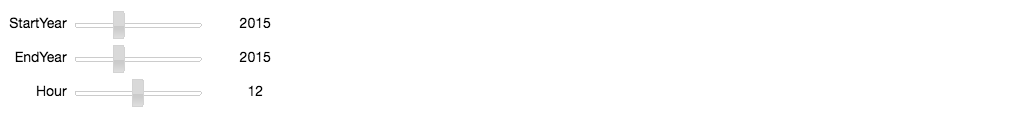

<function __main__.update>

In [20]:
# If Hour == 24
interact(update, StartYear=(2014, 2017), EndYear=(2014, 2017), Hour=(0,24))

## Part 4: Data Analysis

Calculate the mean, median, etc of the data.  
Violations in each region  
Trends year after year compared with cumulative  
Violations during times of day  




## Part 5: Discussion & Conclusions